## 📌 Motivação do experimento

Neste notebook, o objetivo é resolver um **problema real de roteamento urbano**, utilizando dados modelados a partir de um **mapa real** representado como um grafo ponderado.

O cenário considerado é simples, mas extremamente comum no mundo real:

> Dado um ponto fixo (casa x), qual é o **caminho mais curto** até determinados locais de interesse, como:
> - hospital  
> - padaria  
> - mercado  
> - farmácia  
> - academia  

Cada rua, esquina ou ponto de passagem foi modelado como um **nó**, e cada ligação entre dois pontos foi modelada como uma **aresta com peso**, representando a distância em metros.

Esses dados foram organizados em um **arquivo CSV**, que funciona como uma **matriz de adjacência** do grafo.

---

## 🧮 Abordagem inicial: Dijkstra (NetworkX)

Inicialmente, o problema foi resolvido utilizando o **algoritmo de Dijkstra**, através da biblioteca NetworkX.

Essa abordagem permite:
- calcular o caminho mais curto entre dois pontos
- considerar pesos nas arestas (distância)
- obter uma solução exata para o problema de menor caminho

Com isso, foi possível responder perguntas como:
- qual é o caminho mais curto da casa até o hospital
- qual é o caminho mais curto da casa até a padaria
- qual é o caminho mais curto da casa até o mercado

Cada experimento consistia em:
- manter o mesmo grafo
- alterar apenas o destino
- calcular o menor caminho a partir da casa

Essa abordagem funciona muito bem para problemas **origem → destino**.

---

## 🔬 Por que testar OR-Tools?

O objetivo deste notebook é **resolver o mesmo problema**, mas sob uma **outra perspectiva**.

Em vez de utilizar diretamente um algoritmo clássico de grafos, o problema é reformulado como um **problema de otimização** utilizando a biblioteca OR-Tools.

A motivação para isso é:
- entender a diferença entre **algor**


# instalação das libs

In [ ]:
!pip install ortools

In [ ]:
! pip install networkx matplotlib

In [ ]:
! pip install pyvis


In [ ]:
! pip install folium


In [24]:
! pip install plotly

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ------- -------------------------------- 1.8/9.9 MB 14.4 MB/s eta 0:00:01
   ----------------------- ---------------- 5.8/9.9 MB 17.4 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.9 MB 18.2 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.9 MB 18.2 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 10.5 MB/s  0:00:00

   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   --------------

# contrução

In [2]:
import pandas as pd
from ortools.sat.python import cp_model


## import of data

In [3]:
csv_path = "data_cajuru.csv"
df = pd.read_csv(csv_path, index_col=0)

distance_matrix = df.values
num_nodes = len(distance_matrix)

print(f"Número de nós no grafo: {num_nodes}")


Número de nós no grafo: 76


## visualization for data

### NetworkX “bruto, científico” (baseline)

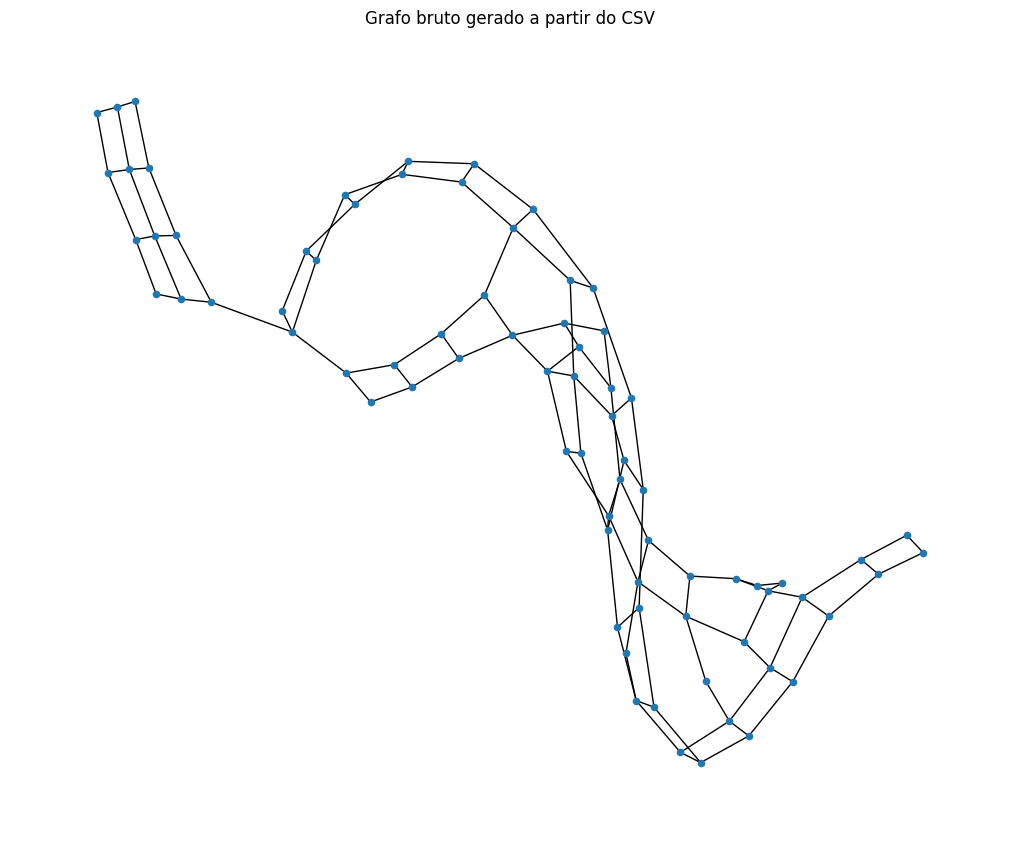

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for i in range(num_nodes):
    for j in range(num_nodes):
        if distance_matrix[i][j] > 0:
            G.add_edge(i, j, weight=distance_matrix[i][j])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=20, with_labels=False)
plt.title("Grafo bruto gerado a partir do CSV")
plt.show()


### PyVis (futurístico / cyberpunk / interativo)

In [18]:
from pyvis.network import Network

net = Network(
    height="750px",
    width="100%",
    bgcolor="#0d1117",
    font_color="white"
)

for i in range(num_nodes):
    net.add_node(i, label=str(i))

for i in range(num_nodes):
    for j in range(num_nodes):
        if distance_matrix[i][j] > 0:
            net.add_edge(i, j, value=distance_matrix[i][j])

net.show("grafo_cajuru_futurista.html")


grafo_cajuru_futurista.html


AttributeError: 'NoneType' object has no attribute 'render'

### Folium (mapa urbano interativo)

In [21]:
import folium
import random

coords = {
    i: (
        -25.45 + random.uniform(-0.01, 0.01),
        -49.25 + random.uniform(-0.01, 0.01)
    )
    for i in range(num_nodes)
}

m = folium.Map(location=[-25.45, -49.25], zoom_start=14)

for i, (lat, lon) in coords.items():
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        popup=f"Nó {i}",
        color="cyan",
        fill=True
    ).add_to(m)

for i in range(num_nodes):
    for j in range(num_nodes):
        if distance_matrix[i][j] > 0:
            folium.PolyLine(
                locations=[coords[i], coords[j]],
                color="gray",
                weight=1
            ).add_to(m)

m


### Plotly (dashboard científico interativo)

In [ ]:
import plotly.graph_objects as go
import networkx as nx
import pandas as pd

# Garante matriz numérica
distance_matrix = df.apply(pd.to_numeric, errors="coerce").fillna(0).values
num_nodes = len(distance_matrix)

G = nx.Graph()

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if distance_matrix[i][j] > 0:
            G.add_edge(i, j)

print("Nós:", G.number_of_nodes())
print("Arestas:", G.number_of_edges())

# Segurança: só continua se houver grafo
if G.number_of_nodes() == 0:
    raise ValueError("O grafo está vazio. Verifique o CSV.")

pos = nx.spring_layout(G, seed=42)

edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

node_x = []
node_y = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"Nó {node}")

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=edge_x,
    y=edge_y,
    mode="lines",
    line=dict(width=0.5, color="gray"),
    hoverinfo="none"
))

fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers",
    marker=dict(size=6, color="cyan"),
    hoverinfo="text",
    text=node_text
))

fig.update_layout(
    title="Visualização interativa do grafo urbano",
    showlegend=False,
    plot_bgcolor="black",
    paper_bgcolor="black",
    font_color="white"
)

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Definir origem e destino

Exemplo:

0 → casa x

45 → hospital 

In [4]:
source = 0
target = 45


## Criar o modelo de otimização (OR-Tools)

Aqui está a diferença conceitual:

- cada aresta possível vira uma variável de decisão  o solver escolhe quais caminhos usar

In [5]:
model = cp_model.CpModel()

# Variáveis: x[i][j] = 1 se o caminho i -> j for usado
x = {}
for i in range(num_nodes):
    for j in range(num_nodes):
        if distance_matrix[i][j] > 0:
            x[(i, j)] = model.NewBoolVar(f"x_{i}_{j}")


## Restrições de fluxo (conceito de grafo)

Essas restrições garantem:

- saída da origem

- chegada no destino

- continuidade do caminho

In [6]:
for node in range(num_nodes):
    incoming = []
    outgoing = []

    for i in range(num_nodes):
        if (i, node) in x:
            incoming.append(x[(i, node)])
    for j in range(num_nodes):
        if (node, j) in x:
            outgoing.append(x[(node, j)])

    if node == source:
        model.Add(sum(outgoing) - sum(incoming) == 1)
    elif node == target:
        model.Add(sum(incoming) - sum(outgoing) == 1)
    else:
        model.Add(sum(incoming) == sum(outgoing))


Função objetivo (minimizar distância total)

In [7]:
model.Minimize(
    sum(distance_matrix[i][j] * x[(i, j)] for (i, j) in x)
)


Resolver o problema

In [8]:
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 10

status = solver.Solve(model)


Extrair o caminho encontrado

In [9]:
if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    print("Caminho encontrado com OR-Tools:\n")

    current = source
    path = [current]
    total_distance = 0

    while current != target:
        for j in range(num_nodes):
            if (current, j) in x and solver.Value(x[(current, j)]) == 1:
                total_distance += distance_matrix[current][j]
                current = j
                path.append(current)
                break

    print(" → ".join(map(str, path)))
    print(f"\nDistância total: {total_distance} metros")
else:
    print("Nenhuma solução encontrada.")


Caminho encontrado com OR-Tools:

0 → 2 → 11 → 12 → 30 → 31 → 29 → 26 → 27 → 44 → 45

Distância total: 935 metros
